# Test intra-speaker variation
Let's look at different uses of integrated/light verb loanwords by the same authors.

This requires identifying the most active authors, which could be a biased sample but YOLO.

In [1]:
import pandas as pd
mined_loanword_data = pd.read_csv('../../data/mined_tweets/loanword_verb_posts_CLUSTER=twitter_posts_STARTDATE=2017_7_9_ENDDATE=2019_4_6.tsv', sep='\t')
extra_loanword_data = pd.read_csv('../../data/mined_tweets/loanword_author_tweets_all_archives_extra_loanword_tweets.gz', sep='\t', compression='gzip')
mined_loanword_data.rename(columns={'user_screen_name' : 'screen_name', 'user_id' : 'author_id'}, inplace=True)
extra_loanword_data.drop(['permalink', 'username', 'date', 'formatted_date', 'mentions', 'hashtags', 'geo', 'urls', 'clean_txt'], axis=1, inplace=True)
loanword_type_lookup = {
    'integrated_verb' : 'integrated_loanword',
    'light_verb' : 'light_verb_loanword',
}
extra_loanword_data = extra_loanword_data.assign(**{
    'loanword_type' : extra_loanword_data.loc[:, 'loanword_type'].apply(loanword_type_lookup.get)
})
combined_loanword_data = pd.concat([mined_loanword_data, extra_loanword_data], axis=0)
# cleanup
drop_cols = ['Unnamed: 0']
combined_loanword_data.drop(drop_cols, inplace=True, axis=1)
# remove shares!
import re
share_matcher = re.compile('^RT @[a-zA-Z0-9_]+')
combined_loanword_data = combined_loanword_data[combined_loanword_data.loc[:, 'text'].apply(lambda x: share_matcher.search(x) is None)]
print(combined_loanword_data.shape[0])
display(combined_loanword_data.head())

75403


,loanword,loanword_verb,loanword_type,screen_name,author_id,text,created_at,id,user_description,user_location,lang,lang_score,retweets,favorites,user_id
0,audit,auditamos,integrated_loanword,GarraChavista,7.793183e+17,@Sheiladarsy @anticuarta4 Y dime tu cuales 7.6...,2017-08-01T22:06:25+00:00,892506833197424640,100% a la izquierda,Venezuela,NaN,NaN,NaN,NaN,NaN
1,ban,baneamos,integrated_loanword,EmmanuelKiller5,4.273648e+09,@adameamiro Eres tan hipocrita que antes nos h...,2017-07-04T23:08:51+00:00,882375684823203841,"Felicidad?Que es eso, lo que todos siempre me ...","Chihuahua, Chihuahua",NaN,NaN,NaN,NaN,NaN
2,ban,baneamos,integrated_loanword,DaniTolocirio13,4.822334e+08,@LVPibai Ibai te hace una normal de reclu? Así...,2017-08-06T00:58:05+00:00,893999585953185793,#21. Me gusta Love Live. Reborn. Baraggan y Es...,"Valladolid, España",NaN,NaN,NaN,NaN,NaN
3,ban,banear,integrated_loanword,VCF973,8.830372e+17,@MiiKeLMsT MIKEEL! CASI ME BANEAN POR COMPRAR ...,2017-08-20T14:29:57+00:00,899277329012334593,.,Tenerife,NaN,NaN,NaN,NaN,NaN
4,ban,banean,integrated_loanword,RedbuHD,1.242443e+09,Iba 1/4 minuto 50 y me banean por xray xddd lo...,2017-07-21T21:24:49+00:00,888510097688739840,ImRedbuh - 13 Wins UHC - Peruvian#PalomasArmy ...,Debajo de tu cama,NaN,NaN,NaN,NaN,NaN


In [2]:
min_post_count = 1
author_var = 'screen_name'
combined_loanword_data = combined_loanword_data.assign(**{
    f'clean_{author_var}' : combined_loanword_data.loc[:, author_var].apply(lambda x: x.lower())
})
author_post_counts = combined_loanword_data.loc[:, f'clean_{author_var}'].value_counts()
freq_authors = author_post_counts[author_post_counts > min_post_count].index.tolist()
print('%d/%d freq authors'%(len(freq_authors), len(author_post_counts)))

5014/67433 freq authors


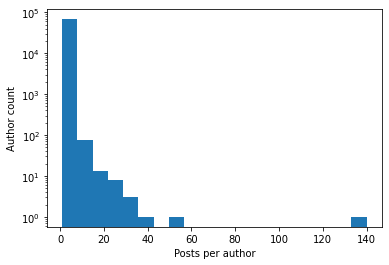

In [68]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(author_post_counts, bins=20)
plt.yscale('log')
plt.xlabel('Posts per author')
plt.ylabel('Author count')
plt.show()

Most people use 5-10 loanwords at most.

### Compute per-author integrated verb rate

Do people show significant variation in integration rates?

In [4]:
# get dummy variable for integrated verbs
integrated_verb_var = 'verb_is_integrated'
combined_loanword_data = combined_loanword_data.assign(**{
    integrated_verb_var : (combined_loanword_data.loc[:, 'loanword_type']=='integrated_loanword').astype(int)
})
author_var = 'screen_name'
clean_author_var = f'clean_{author_var}'
per_author_integrated_verb_rate = combined_loanword_data.groupby(clean_author_var).apply(lambda x: x.loc[:, integrated_verb_var].mean())

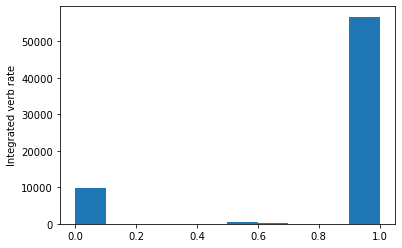

In [5]:
plt.hist(per_author_integrated_verb_rate)
plt.ylabel('Integrated verb rate')
plt.show()

What about the frequent authors?

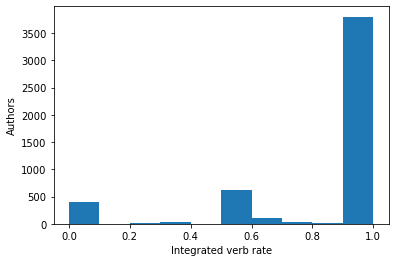

In [6]:
plt.hist(per_author_integrated_verb_rate.loc[freq_authors])
plt.xlabel('Integrated verb rate')
plt.ylabel('Authors')
plt.show()

OK! We see some consistent patterns of variation here. Let's dig into it!

In [11]:
min_integrated_verb_rate = 0.
max_integrated_verb_rate = 1.
valid_authors = per_author_integrated_verb_rate[(per_author_integrated_verb_rate > min_integrated_verb_rate) & 
                                                (per_author_integrated_verb_rate < max_integrated_verb_rate)].index.tolist()
print('%d valid authors'%(len(valid_authors)))

818 valid authors


### Get predictive variables
Let's get the following variables for prediction:

1. hashtag use
2. @-reply use
3. Prior loanword use

In [12]:
import re
hashtag_matcher = re.compile('#[a-zA-Z0-9_]+')
reply_matcher = re.compile('@[a-zA-Z0-9_]+')
combined_loanword_data = combined_loanword_data.assign(**{
    'has_hashtag' : combined_loanword_data.loc[:, 'text'].apply(lambda x: hashtag_matcher.search(x) is not None).astype(int),
    'has_reply' : combined_loanword_data.loc[:, 'text'].apply(lambda x: reply_matcher.search(x) is not None).astype(int),
})

In [13]:
# prior loanword use
# convert date to day (day=t)
from datetime import datetime
from math import floor
import re
def convert_to_day(txt_date, date_matchers, date_formats):
    date_day = None
    for date_matcher, date_format in zip(date_matchers, date_formats):
        try:
            txt_day = date_matcher.search(txt_date.strip()).group(0)
            date_day = datetime.strptime(txt_day, date_format)
        except Exception as e:
            pass
    if(date_day is None):
        print(txt_date)
        raise Exception('bad')
    # round down to nearest day
    if(date_day is not None):
        date_day = datetime(year=date_day.year, month=date_day.month, day=date_day.day)
    return date_day

In [14]:
from data_helpers import convert_to_day
date_var = 'created_at'
date_matchers = [
    re.compile('^[0-9]{4}\-[0-9]{2}\-[0-9]{2}'),
    re.compile('^[A-Z][a-z]{2} [A-Z][a-z]{2} [0-9]{2} [0-9]{2}:[0-9]{2}:[0-9]{2} \+0000 20[0-9]{2}$'),
]
date_formats = [
    '%Y-%m-%d',
    '%a %b %d %H:%M:%S +0000 %Y',
]
# tmp debugging
# x1 = "2017-07-04T23:08:51+00:00 	"
# x2 = 'Tue Aug 07 03:50:00 +0000 2018'
# print(convert_to_day(x1, date_matchers, date_formats))
# print(convert_to_day(x2, date_matchers, date_formats))
date_day_var = 'date_day'
combined_loanword_data = combined_loanword_data.assign(**{
    date_day_var : combined_loanword_data.loc[:, date_var].apply(lambda x: convert_to_day(x, date_matchers, date_formats))
})

In [15]:
from datetime import timedelta
from pandas import Timestamp
def compute_prior_integrated_verb_rate(data, date_var):
    unique_dates = list(map(lambda x: Timestamp(x), data.loc[:, date_var].unique()))
    per_date_integrated_counts = data[data.loc[:, 'verb_is_integrated']==1].loc[:, date_var].value_counts().sort_index(ascending=True)
    # add zeros
    zero_dates = list(set(unique_dates) - set(per_date_integrated_counts.index))
    if(len(zero_dates) > 0):
#     print(zero_dates)
        zero_dates = pd.Series([0,]*len(zero_dates), index=zero_dates)
        per_date_integrated_counts = per_date_integrated_counts.append(zero_dates).sort_index(ascending=True)
#     print(per_date_cumulative_integrated_counts)
    per_date_cumulative_integrated_counts = per_date_integrated_counts.cumsum()
#     print(per_date_cumulative_integrated_counts)
    return per_date_cumulative_integrated_counts

In [16]:
## test with simple data
# author_counts = combined_loanword_data.loc[:, 'clean_screen_name'].value_counts()
# test_author = author_counts.index[5]
test_authors = ['paola_ramirez1', 'alexissandova39']
test_data = combined_loanword_data[combined_loanword_data.loc[:, 'clean_screen_name'].isin(test_authors)]
test_integrated_verb_count_data = test_data.groupby(clean_author_var).apply(lambda x: compute_prior_integrated_verb_rate(x, date_day_var)).reset_index().rename(columns={'level_1' : date_day_var, 'date_day' : 'prior_integrated_loanword_count'})
test_loanword_count = test_data.groupby([clean_author_var]).apply(lambda x: x.loc[:, date_day_var].value_counts().sort_index(ascending=True).cumsum()).reset_index().rename(columns={'level_1' : date_day_var, date_day_var : 'prior_loanword_count'})
# print(test_data.loc[:, ['date_day', 'verb_is_integrated']])
print(test_integrated_verb_count_data)
print(test_loanword_count)

   clean_screen_name   date_day  prior_integrated_loanword_count
0    alexissandova39 2017-07-31                                1
1     paola_ramirez1 2017-07-13                                1
2     paola_ramirez1 2017-07-14                               10
3     paola_ramirez1 2017-07-15                               18
4     paola_ramirez1 2017-07-16                               35
5     paola_ramirez1 2017-07-17                               43
6     paola_ramirez1 2017-07-18                               60
7     paola_ramirez1 2017-07-19                               73
8     paola_ramirez1 2017-07-20                               80
9     paola_ramirez1 2017-07-21                               93
10    paola_ramirez1 2017-07-22                               95
11    paola_ramirez1 2017-07-23                              100
12    paola_ramirez1 2017-07-24                              102
13    paola_ramirez1 2017-07-25                              105
14    paola_ramirez1 2017

In [19]:
author_integrated_loanword_per_date_counts = combined_loanword_data.groupby(clean_author_var).apply(lambda x: compute_prior_integrated_verb_rate(x, date_day_var)).reset_index().rename(columns={'level_1' : date_day_var, date_day_var : 'prior_integrated_loanword_count'})
display(author_integrated_loanword_per_date_counts.head())

,clean_screen_name,date_day,0
0,0001101011001e,2018-05-07,1
1,0001sunshine,2019-05-15,1
2,000822e5bc974e0,2018-08-16,1
3,000i00i,2017-07-13,1
4,00101101k,2019-02-25,1


In [20]:
## offset date var
from datetime import timedelta
def shift_author_dates_forward(data, date_var, author_var, shift=1):
    shifted_data = []
    for author_i, data_i in data.groupby(author_var):
        data_i.sort_values(date_var, ascending=False, inplace=True)
        data_i = data_i.iloc[shift:, :]
#         min_date = data_i.loc[:, date_var].iloc[shift]
#         dummy_dates = [min_date,]*shift
#         data_i.loc[:, date_var] = dummy_dates + data_i.loc[:, date_var].iloc[shift:].values.tolist()
        shifted_data.append(data_i)
    shifted_data = pd.concat(shifted_data, axis=0)
    return shifted_data

In [21]:
## for each author: compute cumulative rate of integrated loanword use until t-1
clean_author_var = 'clean_screen_name'
loanword_var = 'loanword'
date_day_var = 'date_day'
author_loanword_per_date_counts = combined_loanword_data.groupby([clean_author_var]).apply(lambda x: x.loc[:, date_day_var].value_counts().sort_index(ascending=True).cumsum()).reset_index().rename(columns={'level_1' : date_day_var, date_day_var : 'prior_loanword_count'})
author_integrated_loanword_per_date_counts = combined_loanword_data.groupby(clean_author_var).apply(lambda x: compute_prior_integrated_verb_rate(x, date_day_var)).reset_index().rename(columns={'level_1' : date_day_var, 0 : 'prior_integrated_loanword_count'})
display(author_loanword_per_date_counts.head())
display(author_integrated_loanword_per_date_counts.head())
## combine 
author_loanword_prior_counts = pd.merge(author_loanword_per_date_counts, author_integrated_loanword_per_date_counts, on=[clean_author_var, date_day_var])
## compute integration percent
author_loanword_prior_counts = author_loanword_prior_counts.assign(**{
    'integrated_loanword_pct' : author_loanword_prior_counts.loc[:, 'prior_integrated_loanword_count'] / author_loanword_prior_counts.loc[:, 'prior_loanword_count']
})
# author_loanword_prior_counts = author_loanword_prior_counts.assign(**{
#     date_day_var : author_loanword_prior_counts.loc[:, date_day_var] + timedelta(days=1)
# })
date_shift = 1
author_loanword_prior_counts = shift_author_dates_forward(author_loanword_prior_counts, date_day_var, clean_author_var, shift=date_shift)
# print(author_loanword_prior_counts.loc[:, clean_author_var].nunique())
display(author_loanword_prior_counts.head())
## join with prior data
prior_count_vars = ['prior_loanword_count', 'prior_integrated_loanword_count']
for prior_count_var in prior_count_vars:
    if(prior_count_var in combined_loanword_data.columns):
        combined_loanword_data.drop(prior_count_var, axis=1, inplace=True)
full_loanword_data = pd.merge(combined_loanword_data, author_loanword_prior_counts, on=[clean_author_var, date_day_var], how='left')
## fix missing vals
full_loanword_data.fillna(value={prior_count_var : 0. for prior_count_var in prior_count_vars}, inplace=True)
display(full_loanword_data.head())

,clean_screen_name,date_day,prior_loanword_count
0,0001101011001e,2018-05-07,1
1,0001sunshine,2019-05-15,1
2,000822e5bc974e0,2018-08-16,1
3,000i00i,2017-07-13,1
4,00101101k,2019-02-25,1


,clean_screen_name,date_day,prior_integrated_loanword_count
0,0001101011001e,2018-05-07,1
1,0001sunshine,2019-05-15,1
2,000822e5bc974e0,2018-08-16,1
3,000i00i,2017-07-13,1
4,00101101k,2019-02-25,1


/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,clean_screen_name,date_day,prior_loanword_count,prior_integrated_loanword_count,integrated_loanword_pct
12,01800bateria,2017-08-19,1,1,1.0
25,03laaand,2018-10-02,1,1,1.0
34,06danielgomez16,2018-01-05,1,1,1.0
40,0800negro,2017-08-18,1,1,1.0
80,0xidarse_,2017-11-26,1,1,1.0


,loanword,loanword_verb,loanword_type,screen_name,author_id,text,created_at,id,user_description,user_location,...,favorites,user_id,clean_screen_name,verb_is_integrated,has_hashtag,has_reply,date_day,prior_loanword_count,prior_integrated_loanword_count,integrated_loanword_pct
0,audit,auditamos,integrated_loanword,GarraChavista,7.793183e+17,@Sheiladarsy @anticuarta4 Y dime tu cuales 7.6...,2017-08-01T22:06:25+00:00,892506833197424640,100% a la izquierda,Venezuela,...,NaN,NaN,garrachavista,1,0,1,2017-08-01,0.0,0.0,NaN
1,ban,baneamos,integrated_loanword,EmmanuelKiller5,4.273648e+09,@adameamiro Eres tan hipocrita que antes nos h...,2017-07-04T23:08:51+00:00,882375684823203841,"Felicidad?Que es eso, lo que todos siempre me ...","Chihuahua, Chihuahua",...,NaN,NaN,emmanuelkiller5,1,0,1,2017-07-04,0.0,0.0,NaN
2,ban,baneamos,integrated_loanword,DaniTolocirio13,4.822334e+08,@LVPibai Ibai te hace una normal de reclu? Así...,2017-08-06T00:58:05+00:00,893999585953185793,#21. Me gusta Love Live. Reborn. Baraggan y Es...,"Valladolid, España",...,NaN,NaN,danitolocirio13,1,0,1,2017-08-06,1.0,1.0,1.0
3,ban,banear,integrated_loanword,VCF973,8.830372e+17,@MiiKeLMsT MIKEEL! CASI ME BANEAN POR COMPRAR ...,2017-08-20T14:29:57+00:00,899277329012334593,.,Tenerife,...,NaN,NaN,vcf973,1,0,1,2017-08-20,0.0,0.0,NaN
4,ban,banean,integrated_loanword,RedbuHD,1.242443e+09,Iba 1/4 minuto 50 y me banean por xray xddd lo...,2017-07-21T21:24:49+00:00,888510097688739840,ImRedbuh - 13 Wins UHC - Peruvian#PalomasArmy ...,Debajo de tu cama,...,NaN,NaN,redbuhd,1,0,0,2017-07-21,0.0,0.0,NaN


In [22]:
print(combined_loanword_data.shape[0])
print(full_loanword_data[full_loanword_data.loc[:, 'prior_integrated_loanword_count']==full_loanword_data.loc[:, 'prior_loanword_count']].shape[0])
print((1-full_loanword_data.loc[:, 'verb_is_integrated']).sum())

75403
74330
11525


In [23]:
# prior native verb use
import pandas as pd
import numpy as np
native_verb_data = pd.read_csv('../../data/mined_tweets/loanword_author_tweets_all_archives/native_integrated_light_verbs_per_post.tsv', sep='\t')
# dump nan authors?
author_var = 'screen_name'
native_verb_data = native_verb_data[~native_verb_data.loc[:, author_var].apply(lambda x: type(x) is float and np.isnan(x))]
# combine date columns
native_verb_data = native_verb_data.assign(**{
    'date' : native_verb_data.loc[:, 'date'].fillna('') + native_verb_data.loc[:, 'created_at'].fillna('')
})
# convert dates again...yay
native_verb_data
date_day_var = 'date_day'
date_var = 'date'
date_matchers = [
    re.compile('^[0-9]{4}\-[0-9]{2}\-[0-9]{2}'),
    re.compile('^[A-Z][a-z]{2} [A-Z][a-z]{2} [0-9]{2} [0-9]{2}:[0-9]{2}:[0-9]{2} \+0000 20[0-9]{2}$'),
]
date_formats = [
    '%Y-%m-%d',
    '%a %b %d %H:%M:%S +0000 %Y',
]
native_verb_data = native_verb_data.assign(**{
    date_day_var : native_verb_data.loc[:, date_var].apply(lambda x: convert_to_day(x, date_matchers, date_formats))
})
# compute prior native integrated verb count
author_var = 'screen_name'
clean_author_var = 'clean_screen_name'
native_verb_data = native_verb_data.assign(**{
    'verb_is_integrated' : (native_verb_data.loc[:, 'native_word_category']=='native_integrated_verb').astype(int),
    clean_author_var : native_verb_data.loc[:, author_var].apply(lambda x: x.lower()),
})
per_author_native_verb_counts = native_verb_data.groupby([clean_author_var]).apply(lambda x: x.loc[:, date_day_var].value_counts().sort_index(ascending=True).cumsum()).reset_index().rename(columns={'level_1' : date_day_var, date_day_var : 'native_verb_count'})
per_author_native_verb_integrated_counts = native_verb_data.groupby(clean_author_var).apply(lambda x: compute_prior_integrated_verb_rate(x, date_day_var)).reset_index().rename(columns={'level_1' : date_day_var, 0 : 'native_verb_integrated_count'})
# combine
author_native_verb_counts = pd.merge(per_author_native_verb_counts, per_author_native_verb_integrated_counts, on=[clean_author_var, date_day_var], how='left')
# compute native integrated verb percent
author_native_verb_counts = author_native_verb_counts.assign(**{
    'native_verb_integrated_pct' : author_native_verb_counts.loc[:, 'native_verb_integrated_count'] / author_native_verb_counts.loc[:, 'native_verb_count']
})
display(author_native_verb_counts.head())

,clean_screen_name,date_day,native_verb_count,native_verb_integrated_count,native_verb_integrated_pct
0,000822e5bc974e0,2017-09-30,1,1,1.0
1,000822e5bc974e0,2018-10-08,2,2,1.0
2,000822e5bc974e0,2018-10-09,3,3,1.0
3,000822e5bc974e0,2018-10-10,5,5,1.0
4,000822e5bc974e0,2018-10-11,7,7,1.0


In [24]:
def align_counts(data_1, data_2, author_var, date_var, count_var):
    # need to connect count data from data_2 to data_1
    # get count 1 data at time t, align with count 2 data at time {max(t') \in t'<=t}
    aligned_data = []
    for author_i, data_1_i in data_1.groupby(author_var):
        data_2_i = data_2[data_2.loc[:, author_var] == author_i]
        if(data_2_i.shape[0] > 0):
            aligned_data_i = []
            for idx_j, data_1_j in data_1_i.iterrows():
                date_1_j = data_1_j.loc[date_var]
                data_2_j = data_2_i.assign(**{
                    'date_diff' : (date_1_j - data_2_i.loc[:, date_var]).apply(lambda x: x.days)
                })
                data_2_j = data_2_j[data_2_j.loc[:, 'date_diff'] >= 0.]
                if(data_2_j.shape[0] > 0):
                    data_2_j.sort_values('date_diff', inplace=True, ascending=True)
                    data_2_j = data_2_j.iloc[0, :].loc[[count_var]]
                    data_1_j = data_1_j.append(data_2_j)
                    aligned_data_i.append(data_1_j)
            if(len(aligned_data_i) > 0):
                aligned_data_i = pd.concat(aligned_data_i, axis=1).transpose()
                aligned_data.append(aligned_data_i)
    aligned_data = pd.concat(aligned_data, axis=0)
    return aligned_data

In [25]:
author_counts = native_verb_data.loc[:, 'clean_screen_name'].value_counts()
test_authors = author_counts.index[:5]
test_count_data_1 = author_loanword_prior_counts[author_loanword_prior_counts.loc[:, 'clean_screen_name'].isin(test_authors)]
test_count_data_2 = author_native_verb_counts[author_native_verb_counts.loc[:, 'clean_screen_name'].isin(test_authors)]
author_var = 'clean_screen_name'
date_var = 'date_day'
count_var = 'native_verb_integrated_pct'
aligned_test_count_data_1 = align_counts(test_count_data_1, test_count_data_2, author_var, date_var, count_var)
print(aligned_test_count_data_1)

   clean_screen_name   date_day prior_loanword_count  \
0     caraotadigital 2019-04-06                   15   
1     caraotadigital 2019-04-04                   14   
2     caraotadigital 2019-04-03                   13   
3     caraotadigital 2019-02-09                   12   
4     caraotadigital 2019-01-21                   11   
5     caraotadigital 2019-01-20                   10   
6     caraotadigital 2019-01-19                    8   
7     caraotadigital 2019-01-18                    7   
8     caraotadigital 2018-11-24                    6   
9     caraotadigital 2018-11-13                    5   
10    caraotadigital 2018-10-19                    4   
11    caraotadigital 2018-01-30                    3   
12    caraotadigital 2018-01-04                    2   
13    caraotadigital 2017-08-08                    1   
0       eliogarciaap 2017-08-29                    1   
0    noticiasvenezue 2019-02-13                   13   
1    noticiasvenezue 2019-02-08                 

In [26]:
# align all author data
clean_author_var = 'clean_screen_name'
date_var = 'date_day'
count_var = 'native_verb_integrated_pct'
aligned_author_count_data = align_counts(author_loanword_prior_counts, author_native_verb_counts, clean_author_var, date_var, count_var)

In [27]:
print(aligned_author_count_data.loc[:, 'clean_screen_name'].nunique())
print(len(set(aligned_author_count_data.loc[:, 'clean_screen_name'].unique()) & set(full_loanword_data.loc[:, 'clean_screen_name'].unique())))

1960
1960


In [28]:
if('native_verb_integrated_pct' not in full_loanword_data.columns):
    full_loanword_data = pd.merge(full_loanword_data, aligned_author_count_data.loc[:, ['clean_screen_name', 'date_day', 'native_verb_integrated_pct']], on=['clean_screen_name', 'date_day'], how='left')

### Compute post length
Let's compute the length of each post *without* the corresponding verb phrase.

In [29]:
from data_helpers import clean_txt_simple
full_loanword_data = full_loanword_data.assign(**{
    'clean_text' : full_loanword_data.loc[:, 'text'].apply(lambda x: clean_txt_simple(x))
})
# replace all loanword phrases
full_loanword_data = full_loanword_data.assign(**{
    'clean_text_no_word' : full_loanword_data.apply(lambda x: x.loc['clean_text'].replace(x.loc['loanword_verb'], ''), axis=1)
})
full_loanword_data = full_loanword_data.assign(**{
    'clean_text_no_word_len' : full_loanword_data.loc[:, 'clean_text_no_word'].apply(len)
})
# normalize scalar var
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
full_loanword_data = full_loanword_data.assign(**{
    'clean_text_no_word_len' : scaler.fit_transform(full_loanword_data.loc[:, 'clean_text_no_word_len'].values.reshape(-1,1))
})

### Predict within-speaker integrated verb use

In [36]:
# restrict to valid authors, i.e. who posted more than 1x
clean_author_var = 'clean_screen_name'
author_counts = full_loanword_data.loc[:, clean_author_var].value_counts()
min_author_count = 2.
valid_authors = author_counts[author_counts >= min_author_count].index.tolist()
# valid_authors = per_author_integrated_verb_rate[(per_author_integrated_verb_rate > min_integrated_verb_rate) & 
#                                                 (per_author_integrated_verb_rate < max_integrated_verb_rate)].index.tolist()
print('%d/%d valid authors'%(len(valid_authors), full_loanword_data.loc[:, 'clean_screen_name'].nunique()))

5014/67433 valid authors


In [59]:
clean_author_var = 'clean_screen_name'
full_loanword_data = full_loanword_data.assign(**{
    clean_author_var : full_loanword_data.loc[:, 'screen_name'].apply(lambda x: x.lower())
})
# valid_full_loanword_data = full_loanword_data[full_loanword_data.loc[:, clean_author_var].isin(valid_authors)]
# tmp debugging: use all data
valid_full_loanword_data = full_loanword_data.copy()
print('%d valid data'%(valid_full_loanword_data.shape[0]))

75403 valid data


In [60]:
# get freq loanwords, authors
min_word_freq = 10
loanword_var = 'loanword'
loanword_counts = valid_full_loanword_data.loc[:, loanword_var].value_counts()
freq_loanwords = loanword_counts[loanword_counts >= min_word_freq].index.tolist()
valid_full_loanword_data = valid_full_loanword_data.assign(**{
    'freq_loanword' : valid_full_loanword_data.loc[:, loanword_var].apply(lambda x: 'RARE' if x not in freq_loanwords else x)
})
min_author_freq = 10
clean_author_var = 'clean_screen_name'
author_counts = valid_full_loanword_data.loc[:, clean_author_var].value_counts()
freq_authors = author_counts[author_counts >= min_author_freq].index.tolist()
valid_full_loanword_data = valid_full_loanword_data.assign(**{
    'freq_screen_name' : valid_full_loanword_data.loc[:, clean_author_var].apply(lambda x: 'RARE' if x not in freq_authors else x)
})

In [54]:
from statsmodels.discrete.discrete_model import Logit
def run_logit(data, dep_var, indep_vars):
    indep_var_str = '+'.join(indep_vars)
    formula = f'{dep_var} ~ {indep_var_str}'
    model = Logit.from_formula(formula, data=data)
    fit_model = model.fit(method='lbfgs', iters=100)
    # remove fixed effects from output
    model_params = fit_model.params
    model_err = fit_model.bse
    model_pvals = fit_model.pvalues
    model_conf_int = fit_model.conf_int()
    combined_model_params = pd.concat([model_params, model_err, model_pvals, model_conf_int], axis=1)
    combined_model_params.columns = ['coef', 'SE', 'pval', 'CI_lower', 'CI_upper']
    fixed_effect_matcher = re.compile('^C\(.+\)\[T\..+\]$')
    non_fixed_effect_vars = list(filter(lambda x: fixed_effect_matcher.search(x) is None, combined_model_params.index))
    combined_model_params = combined_model_params.loc[non_fixed_effect_vars, :]
    return combined_model_params

In [61]:
dep_var = 'verb_is_integrated'
indep_vars = ['has_hashtag', 'has_reply', 'clean_text_no_word_len', 'C(freq_screen_name)', 'C(freq_loanword)']
combined_model_params = run_logit(valid_full_loanword_data, dep_var, indep_vars)
display(combined_model_params)
print(combined_model_params.to_markdown())

/nethome/istewart6/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


,coef,SE,pval,CI_lower,CI_upper
Intercept,-1.698250,0.098626,1.911889e-66,-1.891554,-1.504946
has_hashtag,0.164062,0.075835,3.050917e-02,0.015429,0.312695
has_reply,-0.214098,0.038449,2.570465e-08,-0.289456,-0.138740
clean_text_no_word_len,0.051790,0.019814,8.952495e-03,0.012956,0.090624


|                        |      coef |        SE |        pval |   CI_lower |   CI_upper |
|:-----------------------|----------:|----------:|------------:|-----------:|-----------:|
| Intercept              | -1.69825  | 0.0986264 | 1.91189e-66 | -1.89155   |  -1.50495  |
| has_hashtag            |  0.164062 | 0.0758345 | 0.0305092   |  0.0154287 |   0.312695 |
| has_reply              | -0.214098 | 0.0384486 | 2.57047e-08 | -0.289456  |  -0.13874  |
| clean_text_no_word_len |  0.05179  | 0.0198136 | 0.00895249  |  0.0129561 |   0.090624 |


OK!

- tweets with hashtags are slightly more likely to have integrated verbs (larger audience => more formal?)
- tweets with replies are **less likely** to have integrated verbs (smaller audience => less formal?)
- longer tweets are not more/less likely to have integrated verbs

Repeat regression but with integrated verb percent as extra variable.

In [62]:
import numpy as np
from sklearn.preprocessing import StandardScaler
clean_valid_full_loanword_data = valid_full_loanword_data.copy()
scalar_vars = ['has_hashtag', 'has_reply', 'clean_text_no_word_len', 'native_verb_integrated_pct', 'integrated_loanword_pct']
scaler = StandardScaler()
for scalar_var in scalar_vars:
    clean_valid_full_loanword_data = clean_valid_full_loanword_data[~clean_valid_full_loanword_data.loc[:, scalar_var].apply(lambda x: np.isnan(x))]
    clean_valid_full_loanword_data = clean_valid_full_loanword_data.assign(**{
        scalar_var : clean_valid_full_loanword_data.loc[:, scalar_var].astype(float)
    })
to_scale_vars = ['clean_text_no_word_len', 'native_verb_integrated_pct', 'integrated_loanword_pct']
for to_scale_var in to_scale_vars:
    # rescale lol
    clean_valid_full_loanword_data = clean_valid_full_loanword_data.assign(**{
        scalar_var : scaler.fit_transform(clean_valid_full_loanword_data.loc[:, to_scale_var].values.reshape(-1,1))
    })
print(clean_valid_full_loanword_data.shape[0])

3727


In [63]:
from statsmodels.discrete.discrete_model import Logit
dep_var = 'verb_is_integrated'
indep_vars = ['has_hashtag', 'has_reply', 'clean_text_no_word_len', 'native_verb_integrated_pct', 'prior_loanword_count', 'C(freq_loanword)', 'C(freq_screen_name)']
combined_model_params = run_logit(clean_valid_full_loanword_data, dep_var, indep_vars)
display(combined_model_params)
print(combined_model_params.to_markdown())

/nethome/istewart6/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


,coef,SE,pval,CI_lower,CI_upper
Intercept,0.099232,0.720204,8.904113e-01,-1.312341,1.510806
has_hashtag,-0.529701,0.380284,1.636470e-01,-1.275044,0.215641
has_reply,-1.373664,0.257296,9.353742e-08,-1.877954,-0.869373
clean_text_no_word_len,0.348499,0.124805,5.232695e-03,0.103886,0.593112
native_verb_integrated_pct,0.139436,0.663300,8.334995e-01,-1.160608,1.439479
prior_loanword_count,-0.046671,0.079765,5.584753e-01,-0.203009,0.109666


|                            |       coef |        SE |        pval |   CI_lower |   CI_upper |
|:---------------------------|-----------:|----------:|------------:|-----------:|-----------:|
| Intercept                  |  0.0992324 | 0.720204  | 0.890411    |  -1.31234  |   1.51081  |
| has_hashtag                | -0.529701  | 0.380284  | 0.163647    |  -1.27504  |   0.215641 |
| has_reply                  | -1.37366   | 0.257296  | 9.35374e-08 |  -1.87795  |  -0.869373 |
| clean_text_no_word_len     |  0.348499  | 0.124805  | 0.0052327   |   0.103886 |   0.593112 |
| native_verb_integrated_pct |  0.139436  | 0.6633    | 0.8335      |  -1.16061  |   1.43948  |
| prior_loanword_count       | -0.0466714 | 0.0797655 | 0.558475    |  -0.203009 |   0.109666 |


- tweets with replies are **less likely** to have integrated verbs (smaller audience)
- tweets written by authors with higher amount of native integrated verb use are **more likely** to have integrated verbs (persistence)

For robustness, let's do ridge regression with L2 penalty to reduce fixed effects.

In [64]:
import sys
if('..' not in sys.path):
    sys.path.append('..')
from importlib import reload
import models.model_helpers
reload(models.model_helpers)
from models.model_helpers import run_regularized_regression
L1_wt = 0.
alpha = 0.001
scalar_vars = ['has_hashtag', 'has_reply', 'clean_text_no_word_len']
cat_vars = ['freq_loanword', 'freq_screen_name']
cat_var_treatment_lookup = {'freq_loanword' : 'RARE', 'freq_screen_name' : 'RARE'}
dep_var = 'verb_is_integrated'
fit_model, fit_model_results = run_regularized_regression(valid_full_loanword_data, dep_var, scalar_vars=scalar_vars, cat_vars=cat_vars, cat_var_treatment_lookup=cat_var_treatment_lookup, l2_weight=alpha)
fixed_effect_matcher = re.compile('^C\(.+\)\[T\..+\]$')
non_fixed_effect_vars = list(filter(lambda x: fixed_effect_matcher.search(x) is None, fit_model_results.index))
fit_model_results = fit_model_results.loc[non_fixed_effect_vars, :]
display(fit_model_results)

/nethome/istewart6/.local/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:1303: UserWarning: GLM ridge optimization may have failed, |grad|=0.000052
  warnings.warn(msg)


,mean,SE,Z,p,CI_lower,CI_upper
Intercept,1.984905,0.156203,12.707191,0.0,1.678752,2.291058
has_hashtag,0.103309,0.014618,7.067061,0.0,0.074657,0.131960
has_reply,-0.153595,0.008742,-17.570344,0.0,-0.170728,-0.136461
clean_text_no_word_len,0.049009,0.004198,11.675324,0.0,0.040782,0.057237


In [66]:
L1_wt = 0.
alpha = 0.001
scalar_vars = ['has_hashtag', 'has_reply', 'clean_text_no_word_len', 'native_verb_integrated_pct', 'prior_loanword_count']
cat_vars = ['freq_loanword', 'freq_screen_name']
cat_var_treatment_lookup = {'freq_loanword' : 'RARE', 'freq_screen_name' : 'RARE'}
dep_var = 'verb_is_integrated'
fit_model, fit_model_results = run_regularized_regression(clean_valid_full_loanword_data, dep_var, scalar_vars=scalar_vars, cat_vars=cat_vars, cat_var_treatment_lookup=cat_var_treatment_lookup, l2_weight=alpha)
fixed_effect_matcher = re.compile('^C\(.+\)\[T\..+\]$')
non_fixed_effect_vars = list(filter(lambda x: fixed_effect_matcher.search(x) is None, fit_model_results.index))
fit_model_results = fit_model_results.loc[non_fixed_effect_vars, :]
display(fit_model_results)

,mean,SE,Z,p,CI_lower,CI_upper
Intercept,0.673001,1.125447,0.597985,7.206527e-01,-1.532835,2.878836
has_hashtag,0.252420,0.048827,5.169632,0.000000e+00,0.156720,0.348120
has_reply,-0.148206,0.052976,-2.797620,4.996004e-15,-0.252037,-0.044375
clean_text_no_word_len,0.230992,0.024999,9.240181,0.000000e+00,0.181995,0.279988
native_verb_integrated_pct,0.718317,0.147560,4.867955,0.000000e+00,0.429104,1.007530
prior_loanword_count,-0.006715,0.008508,-0.789224,5.333673e-01,-0.023391,0.009961


### Test native verbs
Same thing but with native verbs.

In [80]:
# start from scratch
native_verb_data = pd.read_csv('../../data/mined_tweets/loanword_author_tweets_all_archives/native_integrated_light_verbs_per_post.tsv', sep='\t')
# dump nan authors?
author_var = 'screen_name'
native_verb_data = native_verb_data[~native_verb_data.loc[:, author_var].apply(lambda x: type(x) is float and np.isnan(x))]
# combine date columns
native_verb_data = native_verb_data.assign(**{
    'date' : native_verb_data.loc[:, 'date'].fillna('') + native_verb_data.loc[:, 'created_at'].fillna('')
})
# convert dates again...yay
native_verb_data
date_day_var = 'date_day'
date_var = 'date'
date_matchers = [
    re.compile('^[0-9]{4}\-[0-9]{2}\-[0-9]{2}'),
    re.compile('^[A-Z][a-z]{2} [A-Z][a-z]{2} [0-9]{2} [0-9]{2}:[0-9]{2}:[0-9]{2} \+0000 20[0-9]{2}$'),
]
date_formats = [
    '%Y-%m-%d',
    '%a %b %d %H:%M:%S +0000 %Y',
]
native_verb_data = native_verb_data.assign(**{
    date_day_var : native_verb_data.loc[:, date_var].apply(lambda x: convert_to_day(x, date_matchers, date_formats))
})
# compute prior native integrated verb count
author_var = 'screen_name'
clean_author_var = 'clean_screen_name'
native_verb_data = native_verb_data.assign(**{
    'verb_is_integrated' : (native_verb_data.loc[:, 'native_word_category']=='native_integrated_verb').astype(int),
    clean_author_var : native_verb_data.loc[:, author_var].apply(lambda x: x.lower()),
})
per_author_native_verb_counts = native_verb_data.groupby([clean_author_var]).apply(lambda x: x.loc[:, date_day_var].value_counts().sort_index(ascending=True).cumsum()).reset_index().rename(columns={'level_1' : date_day_var, date_day_var : 'native_verb_count'})
per_author_native_verb_integrated_counts = native_verb_data.groupby(clean_author_var).apply(lambda x: compute_prior_integrated_verb_rate(x, date_day_var)).reset_index().rename(columns={'level_1' : date_day_var, 0 : 'native_verb_integrated_count'})
# combine
author_native_verb_counts = pd.merge(per_author_native_verb_counts, per_author_native_verb_integrated_counts, on=[clean_author_var, date_day_var], how='left')
# compute native integrated verb percent
author_native_verb_counts = author_native_verb_counts.assign(**{
    'native_verb_integrated_pct' : author_native_verb_counts.loc[:, 'native_verb_integrated_count'] / author_native_verb_counts.loc[:, 'native_verb_count']
})
display(author_native_verb_counts.head())

,clean_screen_name,date_day,native_verb_count,native_verb_integrated_count,native_verb_integrated_pct
0,000822e5bc974e0,2017-09-30,1,1,1.0
1,000822e5bc974e0,2018-10-08,2,2,1.0
2,000822e5bc974e0,2018-10-09,3,3,1.0
3,000822e5bc974e0,2018-10-10,5,5,1.0
4,000822e5bc974e0,2018-10-11,7,7,1.0


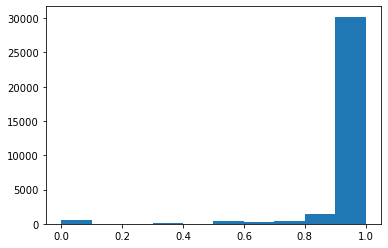

In [51]:
# look for people who consistently switch between integrated, light verb forms
clean_author_var = 'clean_screen_name'
per_author_native_verb_integrated_rate = native_verb_data.groupby(clean_author_var).apply(lambda x: x.loc[:, 'verb_is_integrated'].sum() / x.shape[0])
# plot
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(per_author_native_verb_integrated_rate)
plt.show()

In [57]:
# data cleaning
min_integrated_verb_rate = 0.
max_integrated_verb_rate = 1.
valid_authors = per_author_native_verb_integrated_rate[(per_author_native_verb_integrated_rate > min_integrated_verb_rate) & 
                                                       (per_author_native_verb_integrated_rate < max_integrated_verb_rate)].index.tolist()
print('%d valid authors'%(len(valid_authors)))

6748 valid authors


In [58]:
# shift dates forward for prior native verb use
date_day_var = 'date_day'
clean_author_var = 'clean_screen_name'
date_shift = 1
author_native_verb_prior_counts = shift_author_dates_forward(author_native_verb_counts, date_day_var, clean_author_var, shift=date_shift)

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [59]:
display(author_native_verb_prior_counts.head())

,clean_screen_name,date_day,native_verb_count,native_verb_integrated_count,native_verb_integrated_pct
15,000822e5bc974e0,2018-10-28,23,21,0.913043
14,000822e5bc974e0,2018-10-27,21,19,0.904762
13,000822e5bc974e0,2018-10-25,19,17,0.894737
12,000822e5bc974e0,2018-10-19,18,16,0.888889
11,000822e5bc974e0,2018-10-18,16,16,1.000000


In [ ]:
# regression
from statsmodels.discrete.discrete_model import Logit
dep_var = 'verb_is_integrated'
# indep_vars = ['has_hashtag', 'has_reply', 'C(clean_screen_name)']
indep_vars = ['has_hashtag', 'has_reply', 'clean_text_no_word_len', 'C(freq_native_word_type)', 'C(freq_screen_name)']
indep_var_str = '+'.join(indep_vars)
formula = f'{dep_var} ~ {indep_var_str}'
model = Logit.from_formula(formula, data=valid_full_loanword_data)
fit_model = model.fit(method='lbfgs', iters=100)
# remove fixed effects from output
model_params = fit_model.params
model_pvals = fit_model.pvalues
model_conf_int = fit_model.conf_int()
combined_model_params = pd.concat([model_params, model_pvals, model_conf_int], axis=1)
combined_model_params.columns = ['coef', 'pval', 'CI_lower', 'CI_upper']
fixed_effect_matcher = re.compile('^C\(.+\)\[T\..+\]$')
non_fixed_effect_vars = list(filter(lambda x: fixed_effect_matcher.search(x) is None, combined_model_params.index))
combined_model_params = combined_model_params.loc[non_fixed_effect_vars, :]
display(combined_model_params)
print(combined_model_params.to_markdown())